#### **Step1: Importing Libarries & Environment setup**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.layers import AdditiveAttention, LayerNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

plt.style.use('ggplot')

#### **Step 2: Load and Preprocess the Dataset**

1.Load the dataset.

2.Filter HTTP traffic.

3.Visualize class balance.

4.Select meaningful numeric features.

5.isualize distributions for EDA.

Dataset shape: (25192, 42)

First 5 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


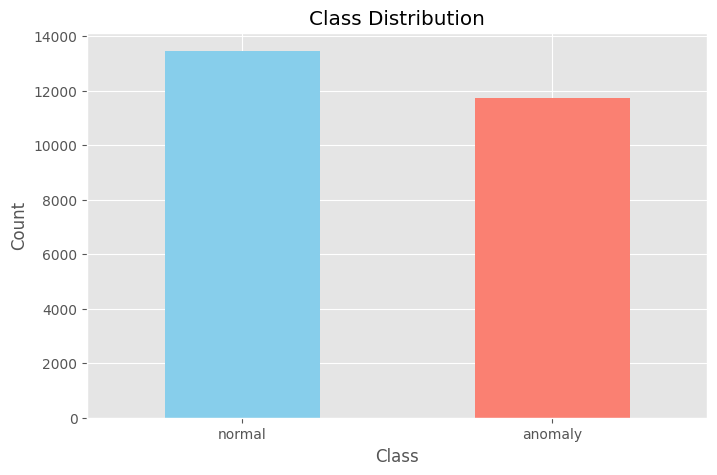


HTTP traffic shape: (8003, 42)


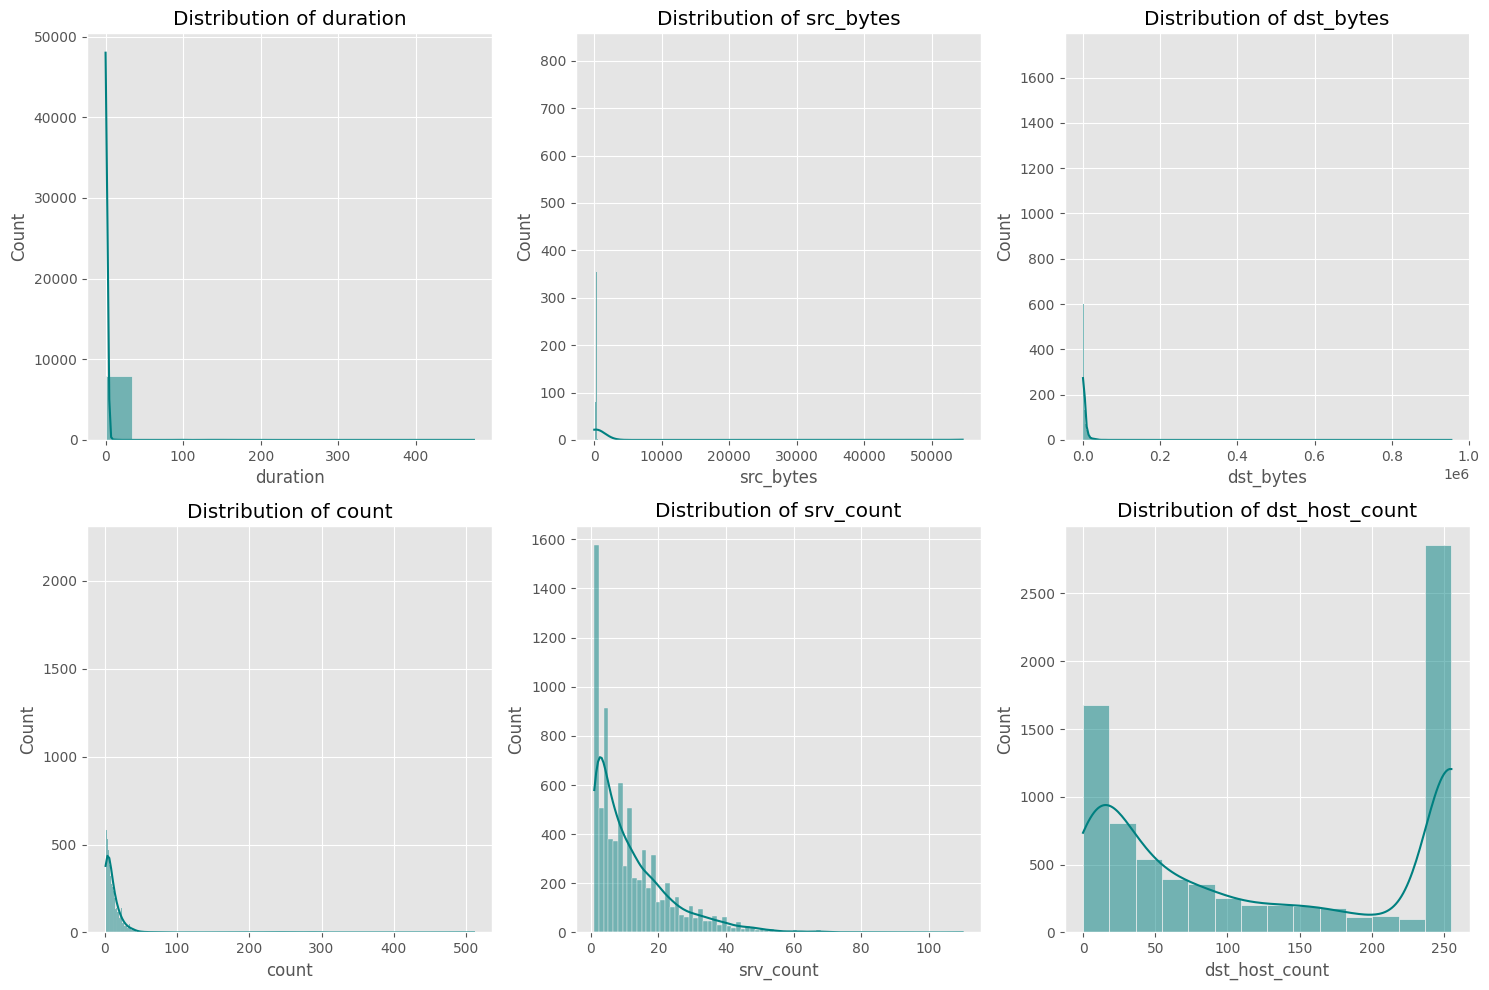

In [ ]:
# Load dataset from local path
data = pd.read_csv('/content/Train_data.csv')
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
display(data.head())

# Plot class distribution
plt.figure(figsize=(8, 5))
data['class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


# Filter only HTTP service data
http_data = data[data['service'] == 'http'].copy()
print("\nHTTP traffic shape:", http_data.shape)

# Focuses only on HTTP traffic (since we're doing HTTP payload anomaly detection).


# Define selected important features for modeling
features = [
    'duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
    'dst_host_count', 'dst_host_srv_count', 'same_srv_rate',
    'diff_srv_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Plot histograms for selected feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features[:6]):  # Only first 6 features
    plt.subplot(2, 3, i+1)
    sns.histplot(http_data[feature], kde=True, color='teal')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


#### **Step3:Data Preprocessing**

In [ ]:

# Encode target
label_encoder = LabelEncoder()
http_data['class_encoded'] = label_encoder.fit_transform(http_data['class'])

# Normalize features
scaler = MinMaxScaler()
http_data[features] = scaler.fit_transform(http_data[features])

# Create sequences
def create_sequences(data, sequence_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data.iloc[i+sequence_length-1]['class_encoded']
        sequences.append(seq[features].values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(http_data)
y = to_categorical(y, num_classes=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (6394, 10, 17)
Test data shape: (1599, 10, 17)


#### **Step4:Building the BiLSTM with Bahdanau Attention model**

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 10, 128), │     41,984 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 10, 128)   │        128 │ bidirectional[0]… │
│ (AdditiveAttention) │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 128)   │          0 │ additive_attenti… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,690 (229.26 KB)

 Trainable params: 58,690 (229.26 KB)

 Non-trainable params: 0 (0.00 B)

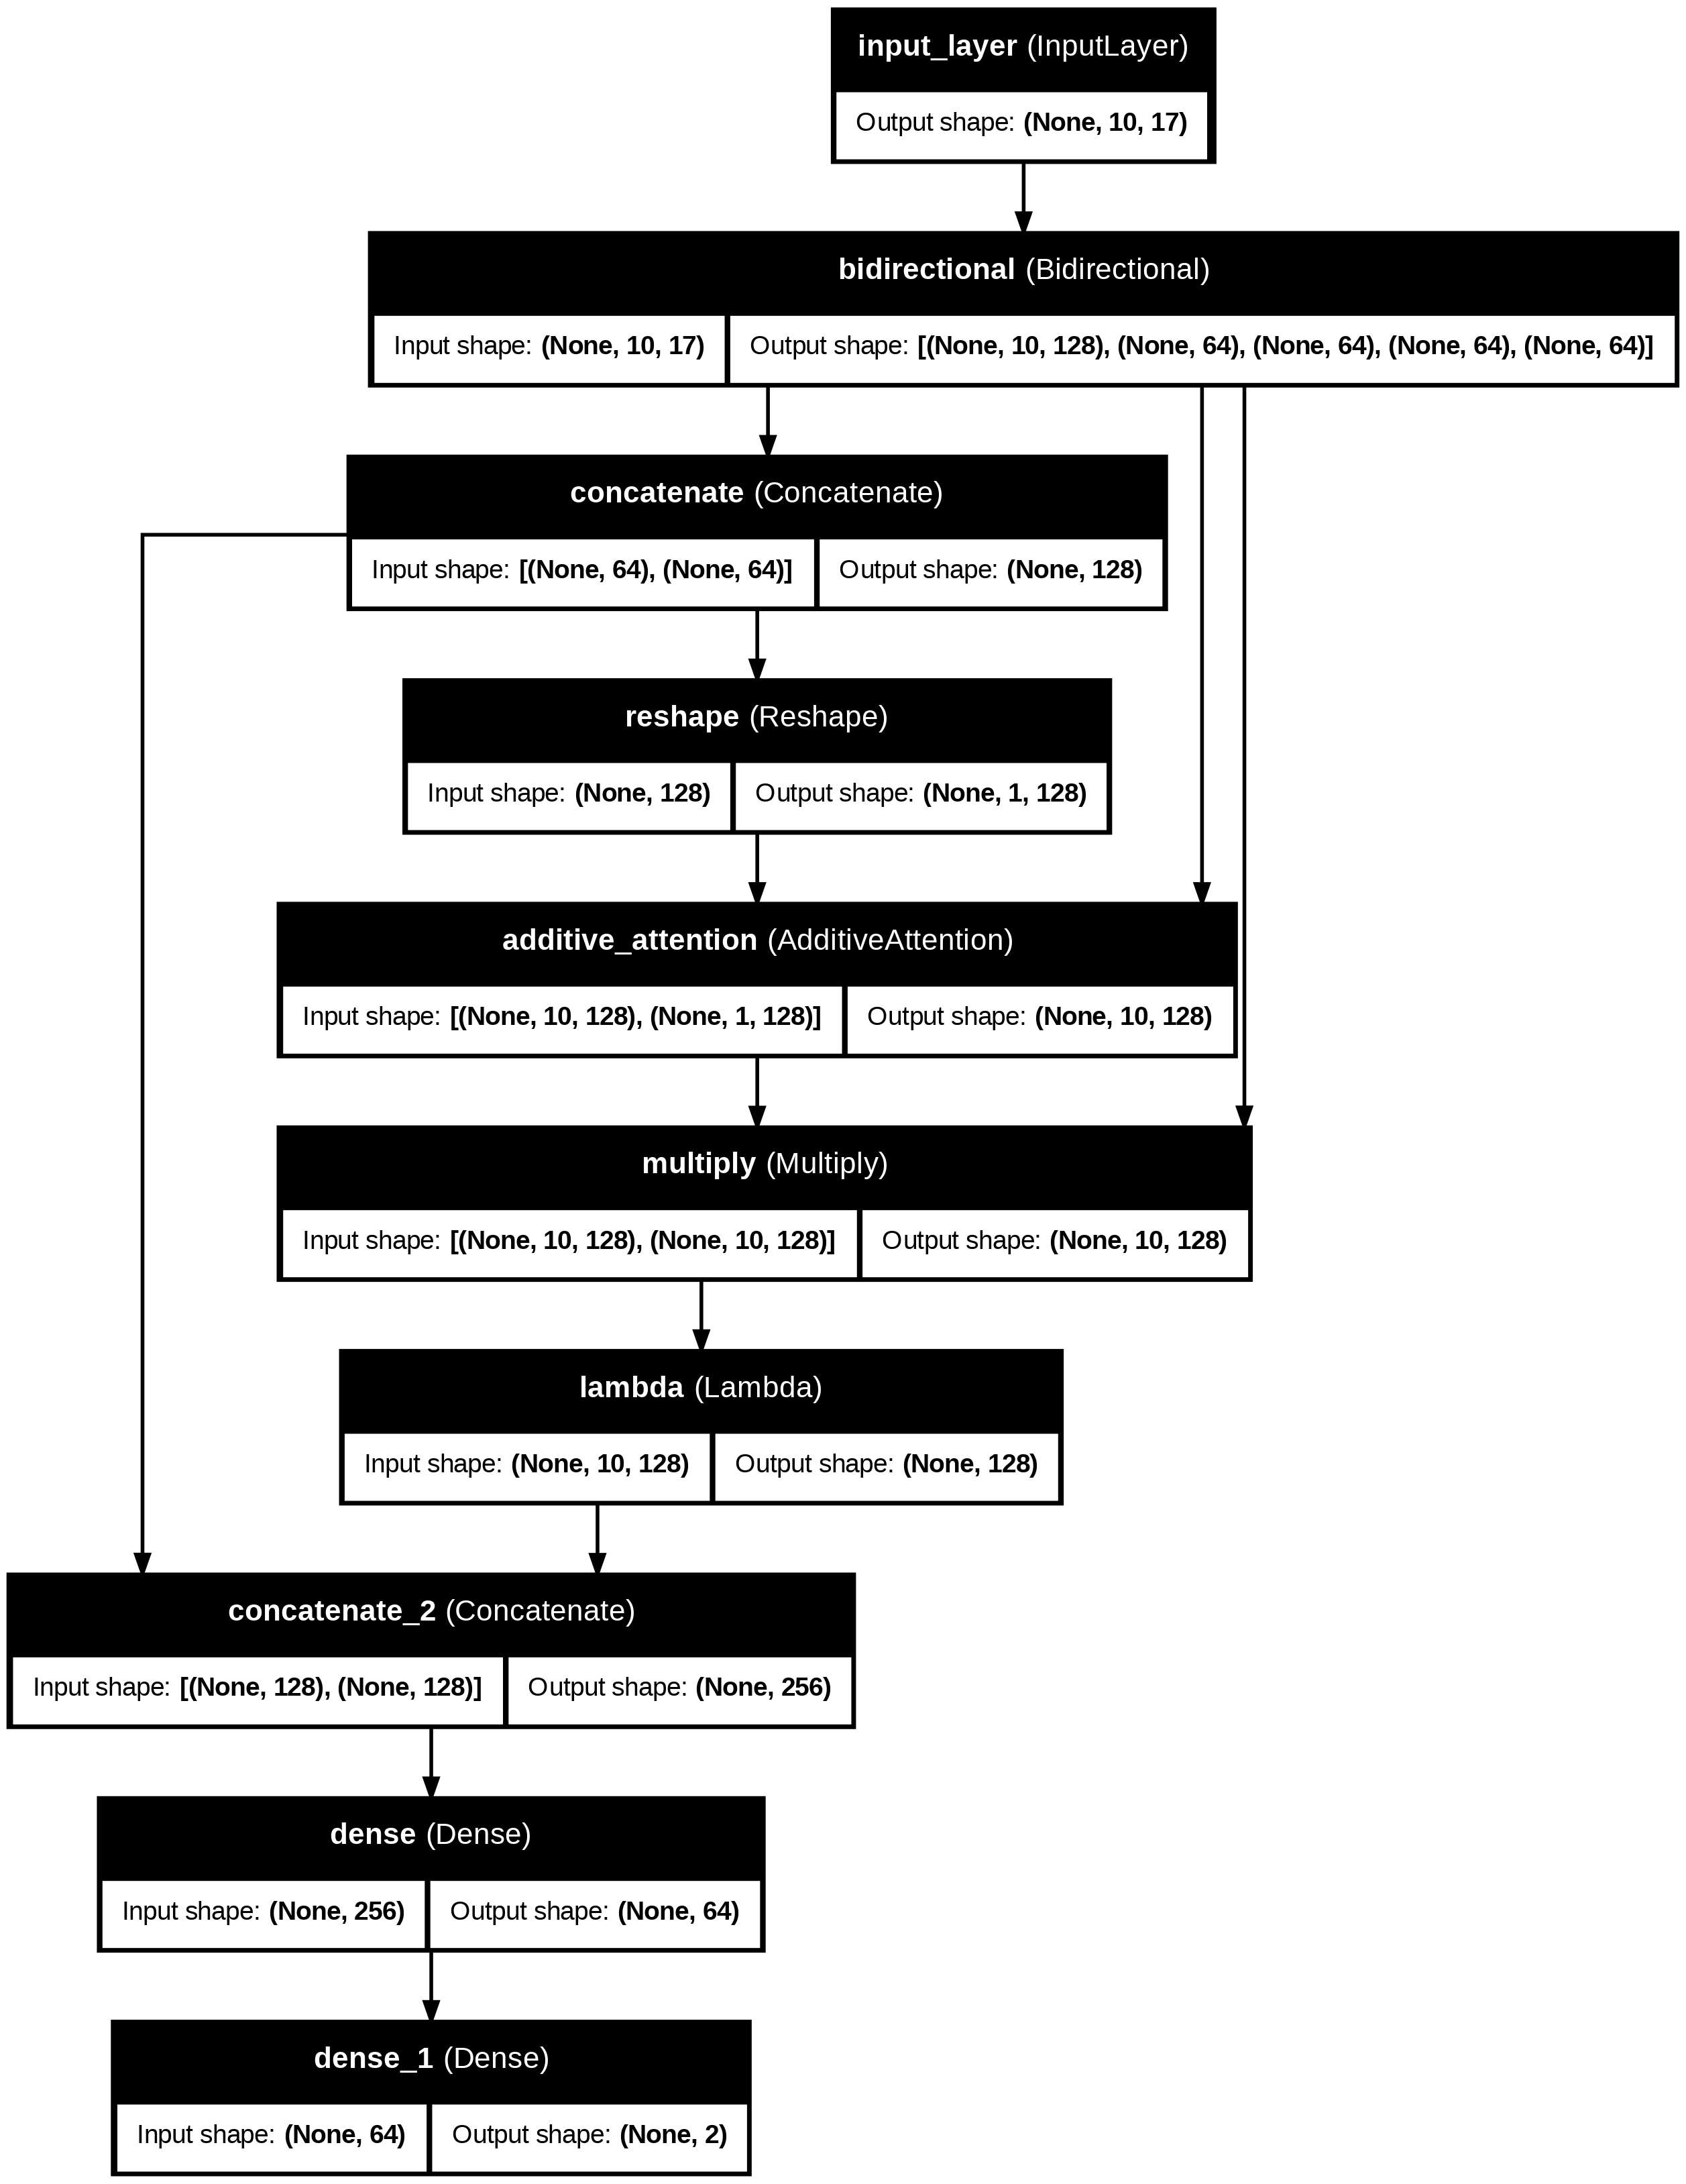

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Dense, AdditiveAttention, Reshape, Multiply, Lambda
from keras.saving import register_keras_serializable
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# First, import the required decorator for serializability
@register_keras_serializable()
def reduce_sum_layer(x):
    return tf.reduce_sum(x, axis=1)

# Parameters
input_dim = X_train.shape[2]  # number of features
sequence_length = X_train.shape[1]  # sequence length
output_dim = y_train.shape[1]  # number of output classes
latent_dim = 64  # LSTM hidden state dimension

# Encoder (BiLSTM)
encoder_inputs = Input(shape=(sequence_length, input_dim))
encoder = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# Concatenate the forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Prepare query for attention (using the last hidden state of the encoder)
query = Reshape((1, latent_dim*2))(state_h)

# Bahdanau Attention mechanism
# Bahdanau Attention calculates the alignment score based on the query and encoder outputs
attention = AdditiveAttention(use_scale=True)([encoder_outputs, query])

# Context vector is the weighted sum of encoder outputs based on the attention weights
context_vector = Multiply()([attention, encoder_outputs])
context_vector = Lambda(reduce_sum_layer,
                       output_shape=(latent_dim*2,))(context_vector)

# Decoder
decoder_input = Concatenate()([context_vector, state_h])  # Concatenate context with the state
decoder_output = Dense(latent_dim, activation='tanh')(decoder_input)
output = Dense(output_dim, activation='softmax')(decoder_output)

# Define the model
model = Model(encoder_inputs, output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary to see layer details
model.summary()

# Optionally, plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


#### **Step5: Training the Model**

In [ ]:

# Set up callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),  # Stops training if validation loss does not improve for 'patience' epochs.
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')  # Saves the model with the best validation loss.
]

# Train the model
history = model.fit(
    X_train, y_train,  # Input training data and labels
    batch_size=64,  # Set batch size (number of samples per gradient update)
    epochs=50,  # Number of iterations over the entire training dataset
    validation_data=(X_test, y_test),  # Use validation data to evaluate the model performance during training
    callbacks=callbacks,  # Apply the callbacks to control training behavior
    verbose=1  # Set to 1 to display progress bar and training info
)

# Load the best model based on validation loss
best_model = tf.keras.models.load_model('best_model.h5')


Epoch 1/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9999 - loss: 3.7371e-04

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9999 - loss: 4.2588e-04 - val_accuracy: 0.9994 - val_loss: 0.0012
Epoch 2/50
 96/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0012

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 6.2270e-04
Epoch 3/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0016

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 5.5347e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 5.9826e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 7.6645e-04 - val_accuracy: 1.0000 - val_loss: 7.4751e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9987 - val_loss: 0.0040
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0010
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accura

#### **Step6: Training Visualization**

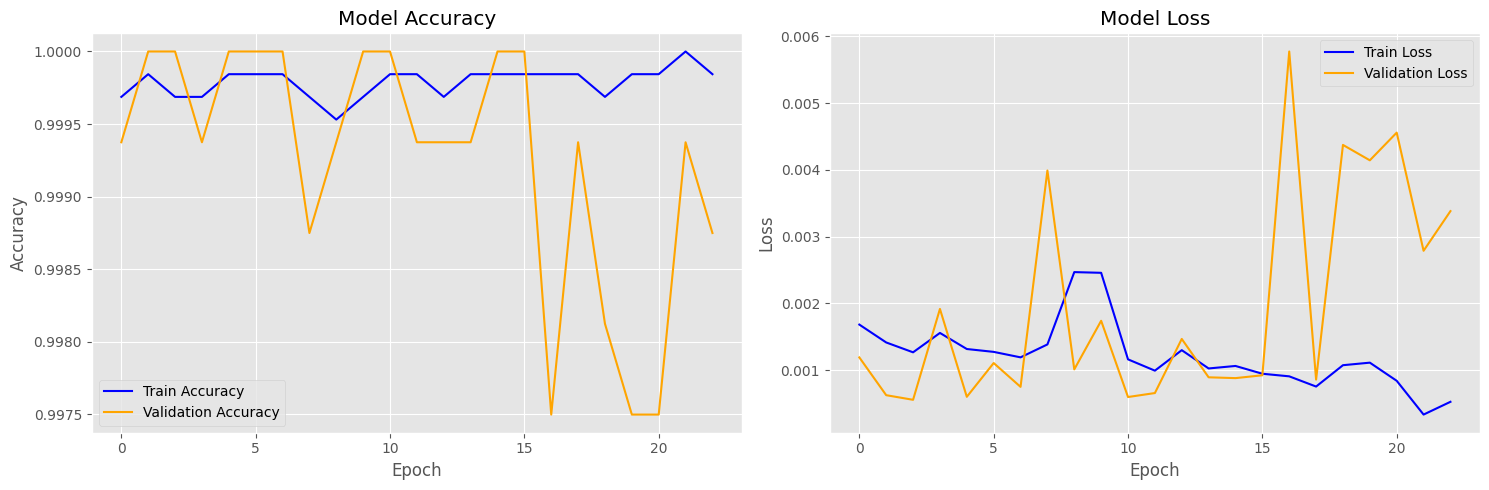

In [ ]:

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

#### **Step7: Model Evaluation**

✅ Evaluates test accuracy

✅ Shows prediction distribution and performance

✅ Computes key classification metrics (confusion matrix, F1 score, ROC-AUC)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 5.8084e-04
Test Accuracy: 100.00%
19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


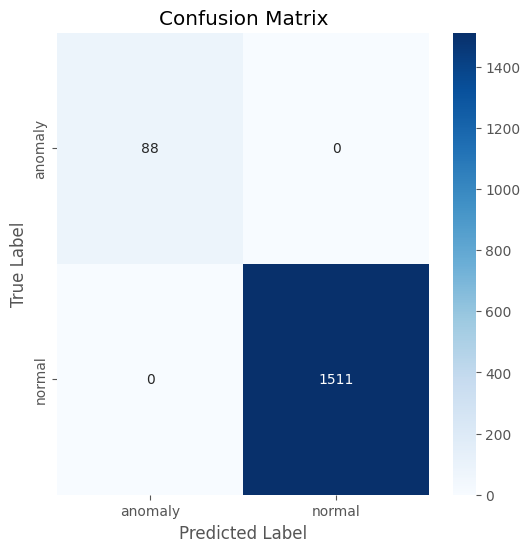


Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00        88
      normal       1.00      1.00      1.00      1511

    accuracy                           1.00      1599
   macro avg       1.00      1.00      1.00      1599
weighted avg       1.00      1.00      1.00      1599



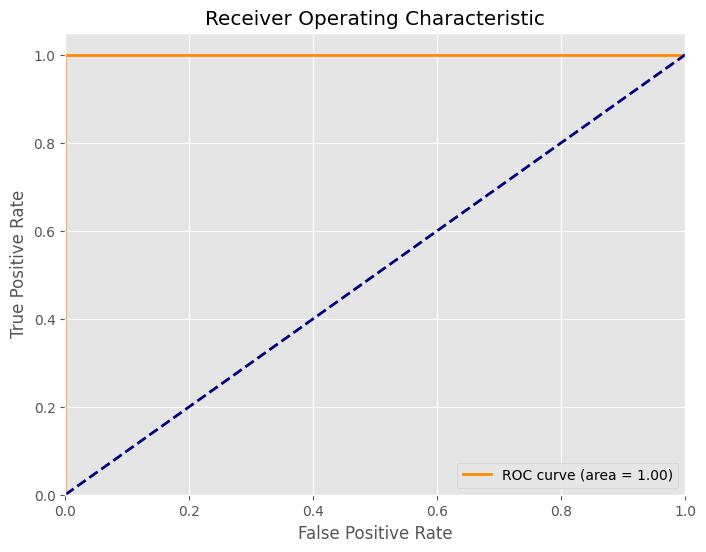

In [ ]:

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Predictions & True Labels
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class indices
y_true = np.argmax(y_test, axis=1)          # Convert one-hot encoded true labels to class indices


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0a0856d2de22783d9673a231a2b6d3c229ef4cfe767bf9b7ab848b358ec224e9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
# BLEU and ROUGE Evaluation for Sequence Labels
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import classification_report
import numpy as np

# Flatten predictions
y_pred_flat = np.ravel(y_pred[:, 1])  # assuming y_pred is softmax or sigmoid output with 2 columns

# Convert numeric labels to text labels
ref_labels = ["normal" if y == 0 else "anomaly" for y in y_true]
pred_labels = ["anomaly" if p > 0.5 else "normal" for p in y_pred_flat]

# BLEU Score with smoothing
smoothie = SmoothingFunction().method4
bleu = corpus_bleu([[ref.split()] for ref in ref_labels],
                   [pred.split() for pred in pred_labels],
                   smoothing_function=smoothie)
print(f"\nBLEU Score (with smoothing): {bleu:.4f}")

# ROUGE Score
ref_text = " ".join(ref_labels)
pred_text = " ".join(pred_labels)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge = scorer.score(ref_text, pred_text)
print(f"ROUGE-1: {rouge['rouge1']}")
print(f"ROUGE-L: {rouge['rougeL']}")


# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(ref_labels, pred_labels, target_names=["normal", "anomaly"]))



BLEU Score (with smoothing): 0.0019
ROUGE-1: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-L: Score(precision=1.0, recall=1.0, fmeasure=1.0)

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1511
     anomaly       1.00      1.00      1.00        88

    accuracy                           1.00      1599
   macro avg       1.00      1.00      1.00      1599
weighted avg       1.00      1.00      1.00      1599



#### **Step8: Anamoly Detection & Visualisation**

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


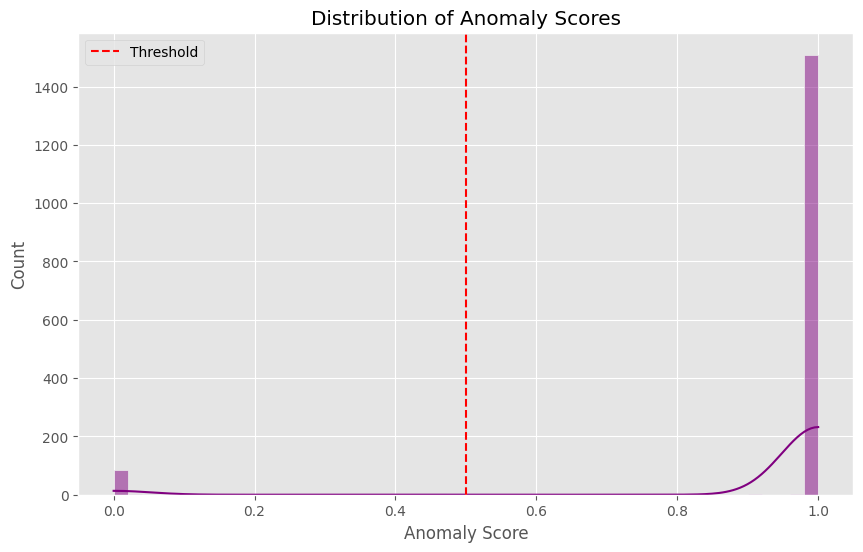


Sample Predictions:


,True Label,Predicted Label,Anomaly Score
0,1,True,1.000000
1,1,True,0.999999
2,1,True,1.000000
3,1,True,0.999997
4,1,True,0.999999
5,1,True,1.000000
6,1,True,0.999997
7,1,True,1.000000
8,1,True,1.000000
9,1,True,1.000000


In [ ]:

def detect_anomalies(model, data, threshold=0.5):
    predictions = model.predict(data)
    anomaly_scores = predictions[:, 1]  # Probability of being an anomaly
    anomalies = anomaly_scores > threshold
    return anomalies, anomaly_scores

anomalies, scores = detect_anomalies(best_model, X_test)

# Plot anomaly scores distribution
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=50, kde=True, color='purple')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# Sample predictions
sample_results = pd.DataFrame({
    'True Label': y_true[:20],
    'Predicted Label': anomalies[:20],
    'Anomaly Score': scores[:20]
})
print("\nSample Predictions:")
display(sample_results)

#### **Step9: Attention Visualisation & Feature Importance Analysis**

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


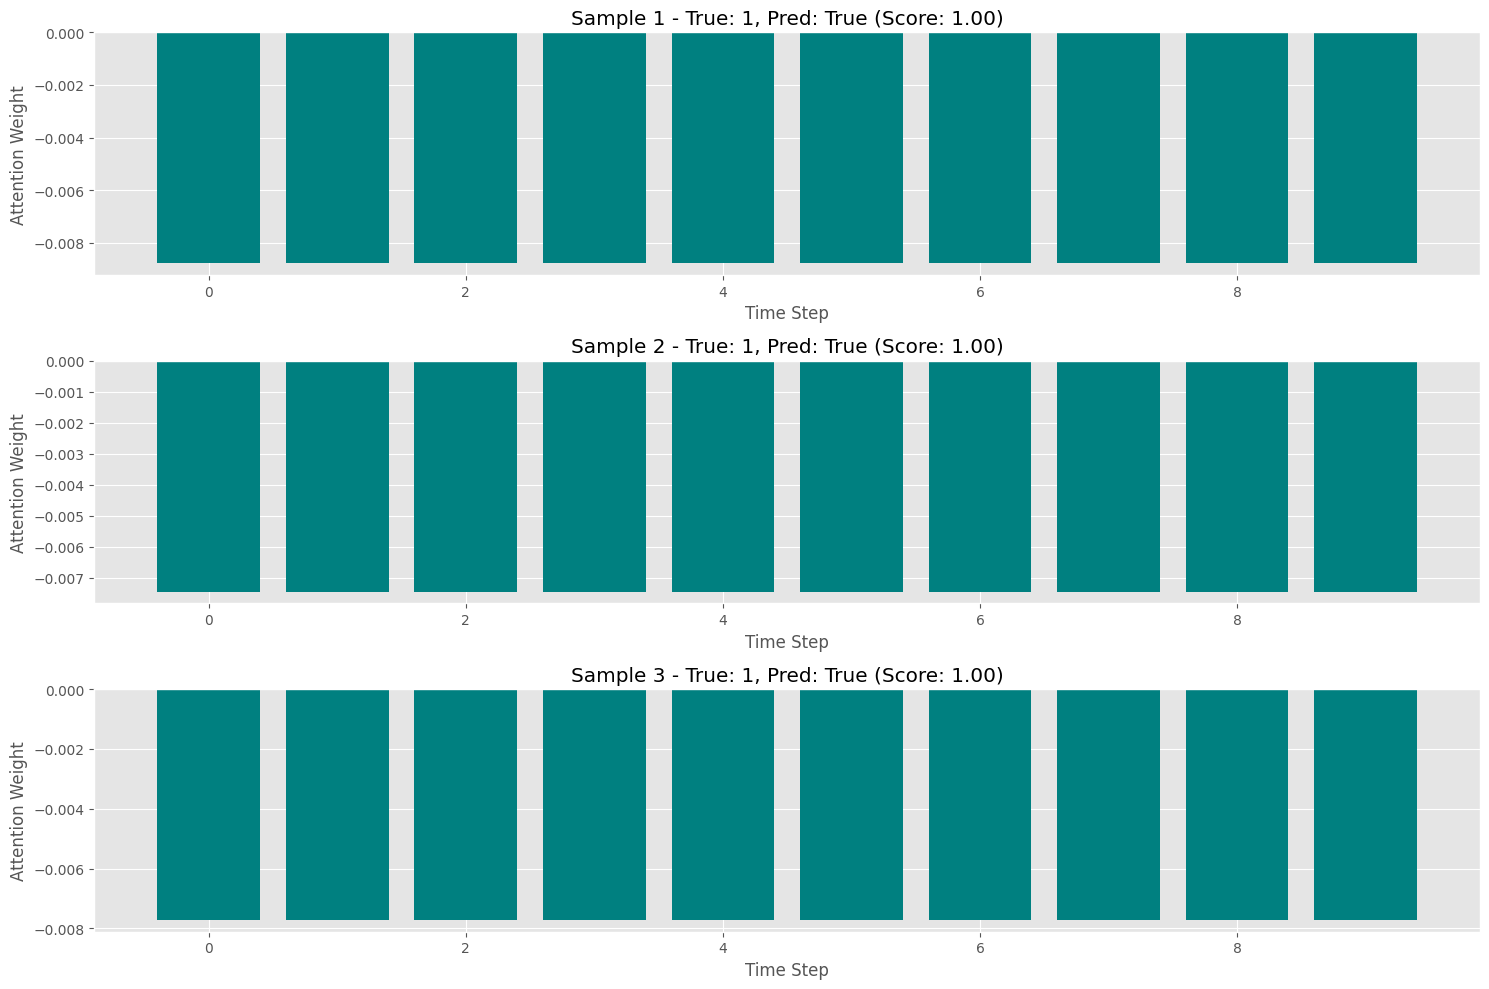


Attention weights shape: (10, 128)
Number of features: 17

Error: Dimension mismatch - Features: 17, Attention: 128
Possible solutions:
1. Check if 'features' list matches your input data
2. Try transposing attention weights (avg_attention.T)
3. Verify your attention layer implementation

Attention stats:
Min: -0.2780
Max: 0.2412
Mean: -0.0089


In [ ]:

# Create attention model
attention_model = Model(
    inputs=encoder_inputs,
    outputs=[output, attention]
)

# ------------------------------------------------------------
# Part 1: Visualize attention weights for sample sequences
# ------------------------------------------------------------
sample_indices = np.random.choice(len(X_test), 3, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    sample_input = X_test[idx:idx+1]
    prediction, attention_weights = attention_model.predict(sample_input, verbose=0)

    # Reshape attention weights (handling potential shape issues)
    if attention_weights.ndim == 3:
        time_step_attention = np.mean(attention_weights[0], axis=-1)  # Average across features
    else:
        time_step_attention = attention_weights[0]  # Use as-is if already 1D

    plt.subplot(3, 1, i+1)
    plt.bar(range(len(time_step_attention)), time_step_attention, color='teal')
    plt.title(f'Sample {i+1} - True: {y_true[idx]}, Pred: {anomalies[idx]} (Score: {scores[idx]:.2f})')
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Part 2: Feature Importance Analysis
# ------------------------------------------------------------
# Get attention weights for 100 samples (or adjust as needed)
n_samples = min(100, len(X_test))
avg_attention = np.mean([attention_model.predict(X_test[i:i+1], verbose=0)[1][0] for i in range(n_samples)], axis=0)

# Debugging information
print("\nAttention weights shape:", avg_attention.shape)
print("Number of features:", len(features))

# Handle different attention weight shapes
if avg_attention.ndim == 2:
    if avg_attention.shape[0] == len(features):  # [features, time]
        feature_importance = np.mean(avg_attention, axis=1)
    elif avg_attention.shape[1] == len(features):  # [time, features]
        feature_importance = np.mean(avg_attention, axis=0)
    else:
        print(f"Warning: Unexpected attention shape {avg_attention.shape}")
        feature_importance = np.mean(avg_attention, axis=0)
else:
    feature_importance = avg_attention  # Use as-is if already 1D

# Create and plot feature importance
if len(features) == len(feature_importance):
    feature_attention = pd.DataFrame({
        'Feature': features,
        'Attention': feature_importance
    }).sort_values('Attention', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Attention', y='Feature', data=feature_attention, palette='viridis')
    plt.title(f'Feature Importance Based on Attention (Averaged over {n_samples} samples)')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nError: Dimension mismatch - Features: {len(features)}, Attention: {len(feature_importance)}")
    print("Possible solutions:")
    print("1. Check if 'features' list matches your input data")
    print("2. Try transposing attention weights (avg_attention.T)")
    print("3. Verify your attention layer implementation")

    # Show raw attention stats for debugging
    print("\nAttention stats:")
    print(f"Min: {np.min(avg_attention):.4f}")
    print(f"Max: {np.max(avg_attention):.4f}")
    print(f"Mean: {np.mean(avg_attention):.4f}")

#### **Step10 : Threshold Analysis**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

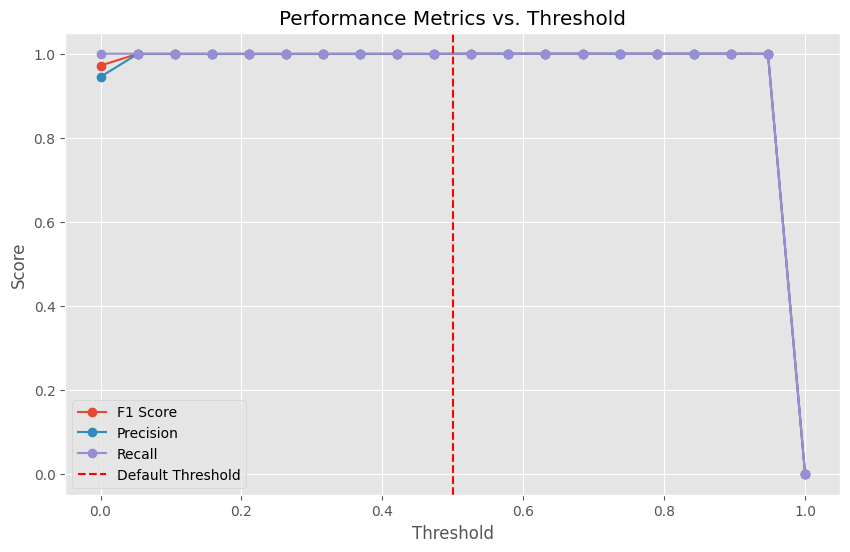

In [ ]:

thresholds = np.linspace(0, 1, 20)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds:
    anomalies = y_pred[:, 1] > thresh
    report = classification_report(y_true, anomalies, output_dict=True)
    f1_scores.append(report['1']['f1-score'])
    precisions.append(report['1']['precision'])
    recalls.append(report['1']['recall'])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold')
plt.title('Performance Metrics vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()